# Main goal: 
Here, we aim to integrate differential analysis results (treated vs. non-treated) toward making a final list of genes which are significantly methylated, expressed and stabilized.

=> table of these genes with all logFCs, pvalues and screening scores.

In [1]:
import pandas as pd 
import numpy as np
from matplotlib.pyplot import subplots
from itertools import chain, product
from venn import venn 

from util import *

### Load data
Comparing treated with Decitabine vs. non-treated:
- **$\Delta$RNA methylation**  (hl60 cell line)
- **$\Delta$Translational efficiency** (hl60 cell line)
- **$\Delta$RNA expression** (For all 6 AML cell lines)
- **$\Delta$RNA stability** (For all 6 AML cell lines)
- **$\Delta$Phenotype, CRISPRi-screen $\rho$(rho) score** (hl60 and molm13 cell lines) 

In [2]:
comps = load_data(comparisons=True)

In [3]:
scrns = load_data(screens=True)

Find top genes across all cell lines and high throughput experiments:


In [4]:
Top = {}

Top['TE']   = set_Top_TE  (0,0.05,comps)
Top['Mtyl'] = set_Top_Mtyl(0,0.05,comps)
Top['Exp']  = set_Top_Exp (0,0.05, 2,comps)
Top['Stbl'] = set_Top_Stbl(0,0.05, 2,comps)
Top['Rho'] = set_Top_Rho(0.1,1,scrns)

Subset Top TE data frame:
up:  40
down: 11
(te_thr=0, fdr_thr=0.05)
Subset Top Mtyl data frame:
up:  2042
down: 1632
(fc_thr=0, pv_thr=0.05)
Subset Top Exp data frame:
up:  2910
down: 2494
(fc_thr=0, pv_thr=0.05) in more than 2 cell lines
Subset Top Stbl data frame:
up:  388
down: 374
(fc_thr=0, pv_thr=0.05) in more than 2 cell lines
Subset Top Rho data frame:
up:  153
down: 182
(sc_thr=0.1, pv_thr=1) in both molm13 and hl60 (2 replicates) cell lines


### Intersection of all genes across different datasets

- https://pypi.org/project/venn/

Select top gene names 

In [5]:
Exp_up = Top['Exp']['up'].gene_name.tolist()
Stbl_up = Top['Stbl']['up'].gene_name.tolist()
TE_up = Top['TE']['up'].gene_name.tolist()
Rho_up = Top['Rho']['up'].index.tolist()
Hyper_m6A = Top['Mtyl']['up'].gene_name.tolist()

Exp_down = Top['Exp']['down'].gene_name.tolist()
Stbl_down = Top['Stbl']['down'].gene_name.tolist()
TE_down = Top['TE']['down'].gene_name.tolist()
Rho_down = Top['Rho']['down'].index.tolist()
Hypo_m6A = Top['Mtyl']['down'].gene_name.tolist()

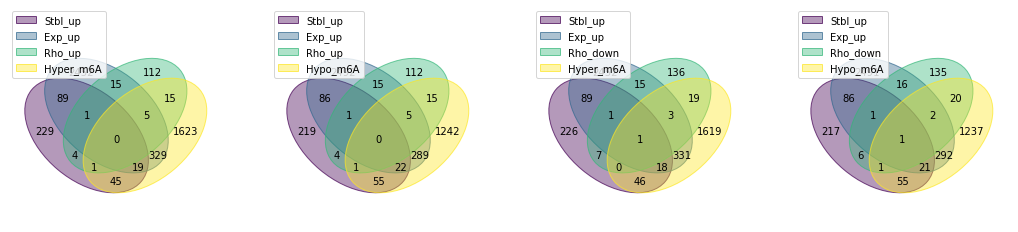

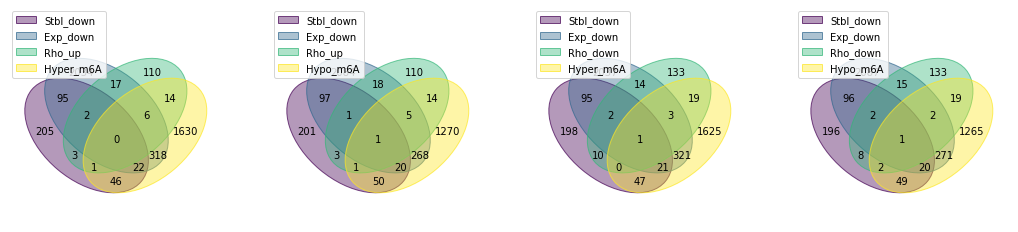

In [6]:
def iter_by_two(input1,input2,input3):
    # inputs are variable names 
    # it will give 8 combinations 
    out = []
    for comb in list(product(input1,input2,input3)):
        a,b,c = comb
        out.append([a,b,c])
    return out 

studies = iter_by_two(['Exp_up', 'Exp_down'],['Rho_up', 'Rho_down'],['Hyper_m6A', 'Hypo_m6A'])
studies = [[s[0].replace('Exp','Stbl'),s[0],s[1],s[2]] for s in studies]

_, top_axs = subplots(ncols=4, nrows=1, figsize=(18, 8))
_, bot_axs = subplots(ncols=4, nrows=1, figsize=(18, 8))
# cmaps = ["cool", list("rgb"), "plasma", "viridis", "Set1"]
# letters = iter(ascii_uppercase)

for std,ax in zip(studies,chain(top_axs, bot_axs)):
    data = {}
    data = dict([[a,set(eval(a))] for a in std])
    venn(data,fontsize=10,legend_loc="upper left", ax=ax)

# Final merged table

In [7]:
# comps = load_data(comparisons=True)
# scrns = load_data(screens=True)

In [22]:
def get_intersect_df(intersect_genes, data, key=None):
    # get intersects 
    # Note: change intersect_genes based on the biological question
    if key is not None: 
        df = data[key]
    else: 
        df = data

    out = df.iloc[[i for i, g in enumerate (df.gene_name) if g in list(intersect_genes)],]

    return out


def filter_genes(genes,df):
    genes = [gene for gene in genes if gene in df.index.tolist()]
    out = df.loc[genes,:]
    return out


def make_comp_final_table(genes,data):
    exp_df = merge_exp_data(data=data)
    stbl_df = merge_stbl_data(data=data)
    
    E = get_intersect_df(genes, exp_df)
    S = get_intersect_df(genes, stbl_df)
    M = get_intersect_df(genes, data['hl60'],'delta_mtyl')
    T = get_intersect_df(genes, data['hl60'],'delta_te')

    out = pd.DataFrame(index=genes)

    out = pd.concat([
        out,
        # Expression
        E.reset_index(drop=True).set_index('gene_name').add_prefix('Exp.'),
        # Stability 
        S.reset_index(drop=True).set_index('gene_name').add_prefix('Stbl.'),
        # Translational Efficiency
        T.reset_index(drop=True).set_index('gene_name').add_prefix('TE.'),
    ],axis=1)
    
    out = out.round(3)
    return out

def make_scrn_final_table(genes,data):
    
    R = merge_screen_data('hl60','rho', data=data)
    R = filter_genes(genes,R)
    G = merge_screen_data('molm13','gamma', data=data)
    G = filter_genes(genes,G)
    
    out = pd.DataFrame(index=genes)
    
    out = pd.concat([
        out,
        # CRISPR Screen Rho score
        R,
        # CRISPR Screen Gamma score
        G,
    ],axis=1)
    
    out = out.round(3)
    return out

# Hypothesis 1
### Rho_down & Exp_down & Stbl_down & Hyper_m6A

In [23]:
hypothesis1 = list(set(Rho_down).intersection(Exp_down,Stbl_down,Hyper_m6A))

In [24]:
make_comp_final_table(hypothesis1,data=comps)

,Exp.hl60.log2FC_120h,Exp.hl60.pval_120h,Exp.kg1.log2FC,Exp.kg1.pval,Exp.molm14.log2FC,Exp.molm14.pval,Exp.ociaml2.log2FC,Exp.ociaml2.pval,Exp.ociaml3.log2FC,Exp.ociaml3.pval,...,Stbl.molm14.logFC,Stbl.molm14.pval,Stbl.ociaml2.logFC,Stbl.ociaml2.pval,Stbl.ociaml3.logFC,Stbl.ociaml3.pval,Stbl.thp1.logFC,Stbl.thp1.pval,TE.Estimate_treatmentDRUG,TE.fdr_Pr...z.._treatmentDRUG
gene_name,,,,,,,,,,,,,,,,,,,,,
PTEN,-0.043,0.244,-0.374,0.005,0.027,0.888,-0.014,0.917,0.174,0.436,...,-0.084,0.462,-0.204,0.276,0.607,0.001,0.027,0.847,0.148,0.908


In [25]:
make_scrn_final_table(hypothesis1,data=scrns)

,hl60_exp1_DAC_rho_score,hl60_exp1_DAC_rho_p-value,hl60_exp2_DAC_rho_score,hl60_exp2_DAC_rho_p-value,hl60_exp2_GSK_rho_score,hl60_exp2_GSK_rho_p-value,molm13_exp_DAC_gamma_score,molm13_exp_DAC_gamma_p-value,molm13_exp_GSK_gamma_score,molm13_exp_GSK_gamma_p-value
gene_name,,,,,,,,,,
PTEN,-0.33,0.0,-0.284,0.097,-0.29,0.002,-0.042,0.806,-0.042,0.806


# Hypothesis 2
### Rho_down & Exp_down & Hyper_m6A

In [26]:
hypothesis2 = list(set(Rho_down).intersection(Exp_down,Hyper_m6A))

In [27]:
make_comp_final_table(hypothesis2,data=comps)

,Exp.hl60.log2FC_120h,Exp.hl60.pval_120h,Exp.kg1.log2FC,Exp.kg1.pval,Exp.molm14.log2FC,Exp.molm14.pval,Exp.ociaml2.log2FC,Exp.ociaml2.pval,Exp.ociaml3.log2FC,Exp.ociaml3.pval,...,Stbl.molm14.logFC,Stbl.molm14.pval,Stbl.ociaml2.logFC,Stbl.ociaml2.pval,Stbl.ociaml3.logFC,Stbl.ociaml3.pval,Stbl.thp1.logFC,Stbl.thp1.pval,TE.Estimate_treatmentDRUG,TE.fdr_Pr...z.._treatmentDRUG
SLFN13,-0.451,0.000,-0.050,0.895,0.708,0.194,0.228,0.451,0.579,0.187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.432,0.491
ATF5,0.136,0.920,0.832,0.003,-1.391,0.000,-0.035,0.859,0.433,0.097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.343,0.730
PTEN,-0.043,0.244,-0.374,0.005,0.027,0.888,-0.014,0.917,0.174,0.436,...,-0.084,0.462,-0.204,0.276,0.607,0.001,0.027,0.847,0.148,0.908
UBXN7,-0.284,0.001,-0.073,0.653,0.506,0.023,0.085,0.580,-0.004,0.987,...,-0.104,0.348,-0.064,0.574,-0.177,0.230,-0.354,0.026,-0.111,0.922


In [28]:
make_scrn_final_table(hypothesis2,data=scrns)

,hl60_exp1_DAC_rho_score,hl60_exp1_DAC_rho_p-value,hl60_exp2_DAC_rho_score,hl60_exp2_DAC_rho_p-value,hl60_exp2_GSK_rho_score,hl60_exp2_GSK_rho_p-value,molm13_exp_DAC_gamma_score,molm13_exp_DAC_gamma_p-value,molm13_exp_GSK_gamma_score,molm13_exp_GSK_gamma_p-value
gene_name,,,,,,,,,,
SLFN13,-0.117,0.386,-0.271,0.121,-0.300,0.380,-0.044,0.943,-0.044,0.943
ATF5,-0.254,0.090,-0.217,0.033,-0.273,0.023,-0.288,0.220,-0.288,0.220
PTEN,-0.330,0.000,-0.284,0.097,-0.290,0.002,-0.042,0.806,-0.042,0.806
UBXN7,-0.106,0.357,-0.201,0.005,-0.267,0.013,-0.043,0.278,-0.043,0.278


# Hypothesis 3

### Rho_up & Exp_down & Stbl_down & Hyper_m6A

In [29]:
hypothesis3 = list(set(Rho_up).intersection(Exp_down,Stbl_down,Hyper_m6A))

In [30]:
make_comp_final_table(hypothesis3,data=comps).shape[0]

0

In [32]:
make_scrn_final_table(hypothesis3,data=scrns)

# Hypothesis 4
### Rho_up & Exp_down & Hyper_m6A

In [33]:
hypothesis4 = list(set(Rho_up).intersection(Exp_down,Hyper_m6A))

In [34]:
make_comp_final_table(hypothesis4,data=comps)

,Exp.hl60.log2FC_120h,Exp.hl60.pval_120h,Exp.kg1.log2FC,Exp.kg1.pval,Exp.molm14.log2FC,Exp.molm14.pval,Exp.ociaml2.log2FC,Exp.ociaml2.pval,Exp.ociaml3.log2FC,Exp.ociaml3.pval,...,Stbl.molm14.logFC,Stbl.molm14.pval,Stbl.ociaml2.logFC,Stbl.ociaml2.pval,Stbl.ociaml3.logFC,Stbl.ociaml3.pval,Stbl.thp1.logFC,Stbl.thp1.pval,TE.Estimate_treatmentDRUG,TE.fdr_Pr...z.._treatmentDRUG
UHRF1,0.532,0.000,-0.204,0.204,-0.341,0.018,-0.206,0.120,-0.195,0.292,...,-0.283,0.036,-0.000,1.000,-0.204,0.176,0.059,0.669,NaN,NaN
SYNCRIP,1.010,0.000,-0.135,0.284,-0.361,0.028,-0.122,0.427,-0.005,0.985,...,-0.078,0.431,-0.043,0.675,0.109,0.349,-0.010,0.931,0.126,0.659
MRPS27,-0.217,0.315,-0.378,0.037,0.065,0.796,-0.313,0.019,0.332,0.286,...,0.175,0.109,0.125,0.258,0.241,0.065,0.091,0.510,-0.224,0.806
SF3B5,1.203,0.004,-0.435,0.045,0.058,0.804,-0.083,0.726,-0.290,0.435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.104,0.921
MRPL17,0.645,0.000,-0.033,0.891,-0.274,0.183,-0.108,0.583,-0.406,0.035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.099,0.928
EP400,0.056,0.733,0.036,0.779,-0.357,0.014,-0.092,0.497,-0.468,0.010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.129,0.771


In [35]:
make_scrn_final_table(hypothesis4,data=scrns)

,hl60_exp1_DAC_rho_score,hl60_exp1_DAC_rho_p-value,hl60_exp2_DAC_rho_score,hl60_exp2_DAC_rho_p-value,hl60_exp2_GSK_rho_score,hl60_exp2_GSK_rho_p-value,molm13_exp_DAC_gamma_score,molm13_exp_DAC_gamma_p-value,molm13_exp_GSK_gamma_score,molm13_exp_GSK_gamma_p-value
gene_name,,,,,,,,,,
UHRF1,0.121,0.043,0.165,0.018,0.411,0.003,-0.093,0.925,-0.093,0.925
SYNCRIP,0.100,0.128,0.184,0.003,0.182,0.019,-0.131,0.311,-0.131,0.311
MRPS27,0.140,0.017,0.101,0.337,0.264,0.003,-0.215,0.001,-0.215,0.001
SF3B5,0.229,0.033,0.111,0.057,0.102,0.294,-0.179,0.018,-0.179,0.018
MRPL17,0.133,0.005,0.260,0.038,0.242,0.023,-0.211,0.249,-0.211,0.249
EP400,0.384,0.004,0.204,0.009,0.172,0.035,-0.275,0.119,-0.275,0.119


# m6A reader and writer genes 
[Table 1](https://www.nature.com/articles/s41419-017-0129-x/tables/1) at
> Dai, D., Wang, H., Zhu, L. et al. N6-methyladenosine links RNA metabolism to cancer progression. _Cell Death Dis_ **9**, 124 (2018). https://doi.org/10.1038/s41419-017-0129-x

In [36]:
table = pd.read_csv('m6A-genes.tsv', sep = '\t')
m6A_genes = table.Names.tolist()
RBMs = m6A_genes[4].split(' and its paralogue ')
m6A_genes.remove(m6A_genes[4])
m6A_genes = m6A_genes+RBMs

In [37]:
make_comp_final_table(m6A_genes,data=comps)

,Exp.hl60.log2FC_120h,Exp.hl60.pval_120h,Exp.kg1.log2FC,Exp.kg1.pval,Exp.molm14.log2FC,Exp.molm14.pval,Exp.ociaml2.log2FC,Exp.ociaml2.pval,Exp.ociaml3.log2FC,Exp.ociaml3.pval,...,Stbl.molm14.logFC,Stbl.molm14.pval,Stbl.ociaml2.logFC,Stbl.ociaml2.pval,Stbl.ociaml3.logFC,Stbl.ociaml3.pval,Stbl.thp1.logFC,Stbl.thp1.pval,TE.Estimate_treatmentDRUG,TE.fdr_Pr...z.._treatmentDRUG
METTL3,-0.112,0.587,-0.081,0.577,0.100,0.606,0.066,0.756,-0.009,0.967,...,-0.096,0.302,0.055,0.669,-0.004,0.976,-0.023,0.827,0.105,0.932
METTL14,-0.088,0.230,0.039,0.844,-0.009,0.966,0.052,0.760,0.223,0.337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.170,0.866
WTAP,-0.134,0.798,0.089,0.749,0.279,0.235,0.046,0.867,0.070,0.815,...,-0.105,0.500,0.001,0.994,-0.118,0.475,-0.078,0.593,-0.024,0.985
KIAA1429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.303,0.050,-0.077,0.449,-0.105,0.341,0.019,0.844,NaN,NaN
METTL16,0.184,0.000,-0.332,0.135,-0.480,0.053,-0.148,0.663,-0.491,0.017,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FTO,-0.620,0.574,-0.250,0.149,-0.834,0.254,0.575,0.146,-0.694,0.007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALKBH5,-0.318,0.403,-0.144,0.410,-0.102,0.517,-0.138,0.356,-0.076,0.667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YTHDC1,0.120,0.596,-0.056,0.702,-0.080,0.609,0.006,0.967,0.100,0.634,...,-0.224,0.152,0.051,0.740,-0.070,0.635,-0.021,0.853,NaN,NaN
YTHDF1,-0.224,0.135,-0.037,0.799,-0.076,0.698,0.035,0.857,-0.123,0.542,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.561,0.395
YTHDF2,-0.177,0.148,0.004,0.977,0.278,0.338,-0.330,0.065,0.145,0.550,...,0.038,0.704,-0.159,0.104,-0.064,0.542,-0.037,0.710,0.100,0.875


In [39]:
make_scrn_final_table(m6A_genes,data=scrns)

,hl60_exp1_DAC_rho_score,hl60_exp1_DAC_rho_p-value,hl60_exp2_DAC_rho_score,hl60_exp2_DAC_rho_p-value,hl60_exp2_GSK_rho_score,hl60_exp2_GSK_rho_p-value,molm13_exp_DAC_gamma_score,molm13_exp_DAC_gamma_p-value,molm13_exp_GSK_gamma_score,molm13_exp_GSK_gamma_p-value
METTL3,0.251,0.001,0.206,0.022,0.257,0.028,-0.304,0.007,-0.304,0.007
METTL14,0.075,0.261,0.142,0.226,0.175,0.137,-0.181,0.001,-0.181,0.001
WTAP,-0.017,0.701,0.074,0.303,0.081,0.592,0.068,0.418,0.068,0.418
KIAA1429,0.207,0.002,0.212,0.003,0.266,0.011,-0.513,0.074,-0.513,0.074
METTL16,-0.079,0.355,0.092,0.298,0.027,0.701,-0.558,0.002,-0.558,0.002
FTO,0.140,0.002,-0.088,0.520,-0.056,0.133,-0.097,0.042,-0.097,0.042
ALKBH5,-0.067,0.187,0.179,0.016,0.127,0.191,0.037,0.641,0.037,0.641
YTHDC1,-0.411,0.000,-0.407,0.003,-0.583,0.000,-0.359,0.036,-0.359,0.036
YTHDF1,0.104,0.087,-0.048,0.712,-0.011,0.820,-0.010,0.459,-0.010,0.459
YTHDF2,0.208,0.001,0.274,0.002,0.324,0.004,-0.109,0.059,-0.109,0.059
